## 线性回归，从零开始实现

只使用张量和自动求导，从零开始实现整个方法， 包括数据流水线、模型、损失函数和小批量随机梯度下降优化器。

In [1]:
import random
import torch
import matplotlib.pyplot as plt

### 1.构造人造数据集

$\mathbf{w} = [2,-3.4]^T, ~ b=4.2, ~ \epsilon \sim \mathcal{N}(0, 0.01), ~ \mathbf{y} = \mathbf{X}\mathbf{w} + b + \epsilon$

In [2]:
def synthetic_data(w, b, num_examples):
    '''生成 y = Xw + b + 高斯噪声'''
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    print(y.shape)
    y += torch.normal(0, 0.01, y.shape)
    print(y.shape)
    return X, y.reshape((-1, 1))                # matmul后，降维了，需要reshape成二维的，方便后面算loss

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

torch.Size([1000])
torch.Size([1000])


features: tensor([ 1.6012, -0.4122]) 
label: tensor([8.7925])


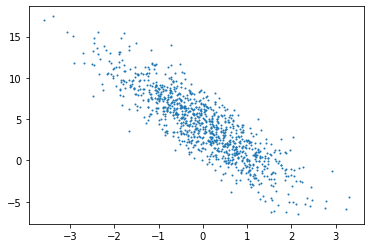

In [3]:
print('features:', features[0], '\nlabel:', labels[0])
plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

### 2.读取数据集

In [4]:
def data_iter(batch_size, features, labels):
    '''构建随机取batch的生成器'''
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        # 步长是batch_size
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]
        # yield类似于返回一个值，并记住返回的位置，下次就从这个位置后开始

In [5]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.4987,  1.2438],
        [ 1.3288,  0.1722],
        [-0.6700, -0.1213],
        [ 1.0924, -1.8950],
        [-1.4319, -0.3140],
        [-0.6953,  0.1876],
        [-1.2894,  0.2998],
        [ 0.3593,  0.4508],
        [-0.1580,  0.5555],
        [ 0.1152,  0.2885]]) 
 tensor([[ 4.9758],
        [ 6.2674],
        [ 3.2672],
        [12.8466],
        [ 2.4056],
        [ 2.1688],
        [ 0.6002],
        [ 3.3830],
        [ 1.9841],
        [ 3.4566]])


### 3.定义模型

初始化模型参数

In [7]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [8]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

定义损失函数

In [9]:
def MSE(y_hat, y):
    '''均方误差'''
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

定义优化算法

In [10]:
def sgd(params, lr, batch_size):
    '''小批量随机梯度下降'''
    with torch.no_grad():
        # 指明此步骤不参与梯度计算
        for param in params:
            param -= lr * param.grad / batch_size           # 按理来说，这里batch_size的归一化应该写在loss计算的时候进行
            param.grad.zero_()

### 4.训练

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = MSE

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)
    with torch.no_grad():
        # 指明此步骤不参与梯度计算：是否有必要？
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.028844
epoch 2, loss 0.000101
epoch 3, loss 0.000053


In [12]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0003, -0.0009], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)
